In [1]:
import xarray as xr
import numpy as np
import sys, glob, os
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
from decimal import Decimal
from eofs.xarray import Eof
from bin_functions import bin_TS
from eof_functions import compute_eof, proj_on_eof
from drift_functions import lag_linregress_3D
plt.style.use('ggplot')

## Read volume T/S piControl and compute linear drift

In [11]:
filespiCV = sorted(glob.glob('/data/ysilvy/bin_TS/volumeTS*piControl*.nc'))
V = xr.open_mfdataset(filespiCV[0:3],combine='by_coords',data_vars='minimal',coords='minimal', compat='override').histogram_so_bigthetao

In [14]:
# Select 210 years to cover 1850-2059 (historical-EXT)
V = V.sel(time=slice('1850','2059'))
V = V.load()

In [19]:
V['time'] = np.arange(1850,2060)

In [21]:
covV,corV,slopeV,interceptV,pvalV,stderrV = lag_linregress_3D(x=V.time,y=V)

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [23]:
V_drift_TS = V.time*slopeV + interceptV
V_dedrift_TS = V - V_drift_TS + V.mean(dim='time')
drift_TS = V - V_dedrift_TS # drift from T-S

In [25]:
# -- Perform EOF
solver_drift=Eof(drift_TS.stack(z=('so_bin', 'bigthetao_bin')))

pcs_drift = solver_drift.pcs(npcs=3)
eofs_drift = solver_drift.eofs(neofs=3)
variance_frac_drift = solver_drift.varianceFraction()
var1_drift = variance_frac_drift[0].data*100
eofs_st_1_drift = eofs_drift[0,:].unstack('z')

Text(0.5, 0.98, 'piControl V-V_dedrifted calculated in TS')

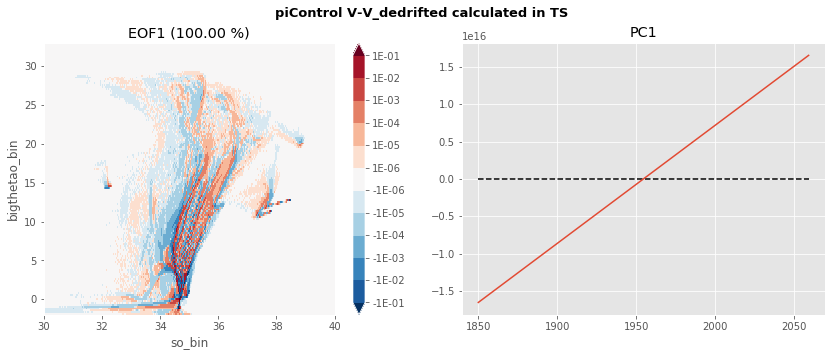

In [29]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = V.time

levels = [-1.e-1,-1.e-2,-1.e-3,-1.e-4,-1.e-5,-1.e-6,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
levels_str = ['%.0E' % Decimal(str(w)) for w in levels]

c = eofs_st_1_drift.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_drift))+'%)')
ax[1].plot(time,pcs_drift[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')


plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = 'piControl V-V_dedrifted calculated in TS'

plt.suptitle(title,fontsize=13,fontweight='bold')

# plt.savefig('drift_TS_picontrol.png') #002501 #0105

## Read T and S in geographical coordinates, calculate linear drift and bin in T-S space 

In [32]:
# -- Select files
filespiCT = sorted(glob.glob('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Omon/bigthetao/gn/latest/*.nc'))[0:3]
filespiCS = sorted(glob.glob('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Omon/so/gn/latest/*.nc'))[0:3]
filespiCZ = sorted(glob.glob('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Omon/thkcello/gn/latest/*.nc'))[0:3]

In [35]:
# -- Read areacello
farea = '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Ofx/areacello/gn/latest/areacello_Ofx_IPSL-CM6A-LR_historical_r1i1p1f1_gn.nc'
area = xr.open_dataset(farea)

In [37]:
# -- Define bin resolution
c = 10
deltaS = 0.025
deltaT = c*deltaS
sbins = np.arange(30,40.001, deltaS) 
tbins = np.arange(-2, 33.001, deltaT)

In [40]:
def annual_mean(filein,varname):
    # Read variable (monthly)
    var = xr.open_mfdataset(filein,combine='by_coords',data_vars='minimal',coords='minimal', compat='override', chunks={'time':12})[varname]
    var = var.sel(time=slice('1850','2059'))
    # Make annual mean
    varyr = var.resample(time='Y').mean()
    return varyr

In [41]:
# -- Read monthly files and make annual mean
T = annual_mean(filespiCT,'bigthetao')
S = annual_mean(filespiCS,'so')
Z = annual_mean(filespiCZ,'thkcello')

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


In [ ]:
# -- Linear regression for S and T
S['time'] = np.arange(1850,2060)
T['time'] = np.arange(1850,2060)
Z['time'] = np.arange(1850,2060)
covS,corS,slopeS,interceptS,pvalS,stderrS = lag_linregress_3D(x=S.time,y=S)  
covT,corT,slopeT,interceptT,pvalT,stderrT = lag_linregress_3D(x=T.time,y=T)

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/reductions.py:408: RuntimeWarning: divide by zero encountered in true_divide
  u = total / n
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/reductions.py:408: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_di

In [ ]:
S_drift = S.time*slopeS + interceptS
T_drift = T.time*slopeT + interceptT
S_dedrift = S - S_drift + S.mean(dim='time')
T_dedrift = T - T_drift + T.mean(dim='time')

In [ ]:
# S_dedrift = S_dedrift.to_dataset(name='so')
# T_dedrift = T_dedrift.to_dataset(name='thetao')

In [ ]:
def bin_TS(S,T,vol,sbins,tbins):
    """Bin volume at each time step and create 3rd dimension to save data"""
    # Initialize
    hTS_0 = histogram(S.isel(time=0), T.isel(time=0), bins=[sbins,tbins], weights=vol.isel(time=0))
    hTS_0['time'] = T.time[0]
    hTS_0 = hTS_0.expand_dims('time') 
    V = hTS_0.compute()
    # Loop
    for it in range(1,len(T.time)):
        hTS = histogram(S.isel(time=it), T.isel(time=it), bins=[sbins,tbins], weights=vol.isel(time=it))
        hTS['time'] = T.time[it]
        hTS = hTS.expand_dims('time') 
        V = xr.concat([V, hTS], dim='time').compute()
    return V

In [ ]:
# -- Create volume from thickness of z levels (time-varying) and area of gridcells (fixed in time)
vol = Z*area.areacello

# -- Bin volume in T-S space
V_dedrift_bis = bin_TS(S,T,vol,sbins,tbins)

In [ ]:
drift_TS_bis = V - V_dedrift_bis # drift from geographical coordinates
drift_TS_bis = drift_TS_bis.load()

In [ ]:
# -- Perform EOF
solver_driftbis=Eof(drift_TS_bis.stack(z=('so_bin', 'thetao_bin')))

pcs_driftbis = solver_driftbis.pcs(npcs=3)
eofs_driftbis = solver_driftbis.eofs(neofs=3)
variance_frac_driftbis = solver_driftbis.varianceFraction()
var1_driftbis = variance_frac_driftbis[0].data*100
eofs_st_1_driftbis = eofs_driftbis[0,:].unstack('z')

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(14,10))

time = np.arange(1850,2060)

c = eofs_st_1_drift.T.plot(ax=ax[0,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_drift))+'%)')
ax[0,1].plot(time,pcs_drift[:,0])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')

c = eofs_st_1_driftbis.T.plot(ax=ax[1,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[1,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[1,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_driftbis))+'%)')
ax[1,1].plot(time,pcs_driftbis[:,0])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = 'piControl V-V_dedrifted \n a. Drift calculated in TS b. in geographical coordinates'

plt.suptitle(title,fontsize=13,fontweight='bold')

# plt.savefig('drift_TS_picontrol.png') #002501 #0105